Primero se cargan los datos de los archivos 'PPS.log' y 'measurements.log' respectivamente.

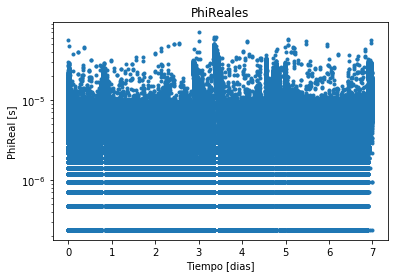

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from leerArchivos import *
import random

#Si se cambia matplotlib de 'inline' a 'notebook' se usan graficos interactivos.
%matplotlib inline

pps, phiReales = obtenerPPS('PPS.log')
tiempos, phiNTP, rtts = obtenerMediciones('measurements.log')

#Se muestra en el eje del tiempo las mediciones en dias. Para eso es necesario recalcular el indice.
indice = np.arange(len(phiReales))*(7/len(phiReales)) 

plt.semilogy()
plt.plot(indice, phiReales, '.')
plt.title('PhiReales')
plt.ylabel('PhiReal [s]')
plt.xlabel('Tiempo [dias]')

plt.show()

Se calcula el histograma del RTTs como paso previo a obtener la funcion de densidad de probabilidad del mismo.

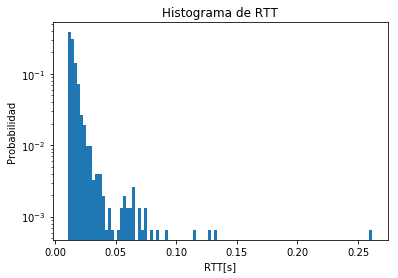

In [2]:
#'pesos' es una arreglo con el peso de cada medicion sobre el total. Asi se maneja para que los valores sumen 1 en total. 
pesos = np.ones_like(rtts)/len(rtts)
p, bins, patches = plt.hist(rtts, 100, weights=pesos)

plt.title('Histograma de RTT')
plt.ylabel('Probabilidad')
plt.xlabel('RTT[s]')

plt.semilogy()
plt.savefig("hist_rtt.pdf")
plt.show()

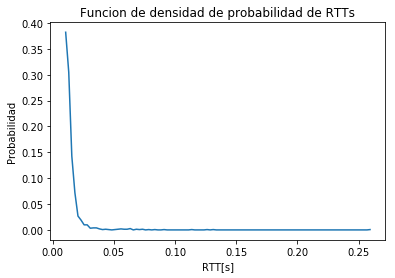

In [3]:
plt.plot(bins[0:len(p)], p)
plt.title('Funcion de densidad de probabilidad de RTTs')
plt.ylabel('Probabilidad')
plt.xlabel('RTT[s]')

plt.show()

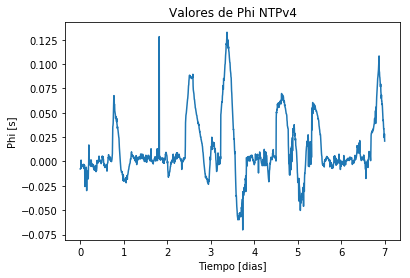

In [4]:
#Se muestra en el eje del tiempo las mediciones en dias. Para eso es necesario recalcular el indice.
indice = np.arange(len(phiNTP))*(7/len(phiNTP)) 

plt.plot(indice, phiNTP)

plt.title('Valores de Phi NTPv4')
plt.ylabel('Phi [s]')
plt.xlabel('Tiempo [dias]')
plt.savefig("phi_ntp.pdf")
plt.show()



Lo que se hace como paso siguiente es aparear las mediciones de NTP con los PPS y determinar en que momento del PPS se tomo cada una de dichas mediciones.

Luego se expanden las mediciones, esto es, ya que NTP en regimen permanente envia un paquete cada 64s, aproximadamente los 63 PPS intermedios no tendran correspondencia con ninguna medicion, entonces se repiten los valores de estas mediciones para asegurar la mencionada correspondecia.

Finalmente los phiReales se acortaran quitando los PPS que pasaron luego de la ultima medicion de NTP registrada.

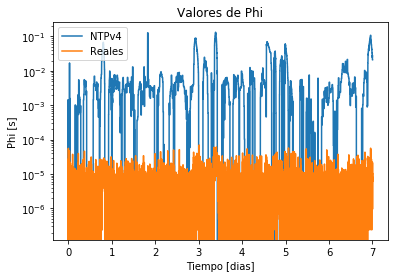

In [5]:
from acondicionamientoEntrada import *

indices = asignarMedicionesPPS(tiempos, pps)
phiRealesAcortada, phiNTPExtendido = expandirMediciones(indices, phiReales, phiNTP)

#Se muestra en el eje del tiempo las mediciones en dias. Para eso es necesario recalcular el indice.
indiceTiempo = np.arange(len(phiNTPExtendido))*(7/len(phiNTPExtendido)) 

plt.semilogy()
plt.plot(indiceTiempo, phiNTPExtendido, label='NTPv4')
plt.plot(indiceTiempo, phiRealesAcortada, label='Reales')

plt.ylabel('Phi [s]')
plt.xlabel('Tiempo [dias]')

plt.title('Valores de Phi')
plt.legend(loc='upper left')
plt.savefig("comparacion_phi_ntp.pdf")
plt.show()


Se calcula el Error de tiempo para poder calcular el MTIE.

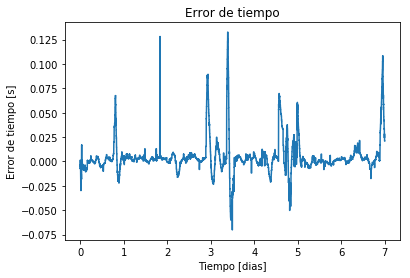

In [6]:
from evaluacion import *

TE = [x - y for x, y in zip(phiNTPExtendido, phiRealesAcortada)]

plt.plot(indiceTiempo, TE)

plt.title("Error de tiempo")

plt.ylabel('Error de tiempo [s]')
plt.xlabel('Tiempo [dias]')
plt.savefig("error_ntp.pdf")
plt.show()



Primero se calcula un caso particular de MTIE para NTP con ventanas disjuntas de distintos tamaños.

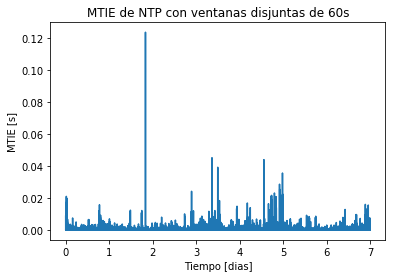

In [7]:
MTIE60 = calcularMTIE(60, phiNTPExtendido, TE, pps, 60)
MTIE120 = calcularMTIE(120, phiNTPExtendido, TE, pps, 120)
MTIE180 = calcularMTIE(180, phiNTPExtendido, TE, pps, 180)
MTIE300 = calcularMTIE(300, phiNTPExtendido, TE, pps, 300)

#Se muestra en el eje del tiempo las mediciones en dias. Para eso es necesario recalcular el indice.
indiceTiempo = np.arange(len(MTIE60))*(7/len(MTIE60)) 
plt.plot(indiceTiempo, MTIE60)

plt.title("MTIE de NTP con ventanas disjuntas de 60s")
plt.ylabel('MTIE [s]')
plt.xlabel('Tiempo [dias]')
plt.show()

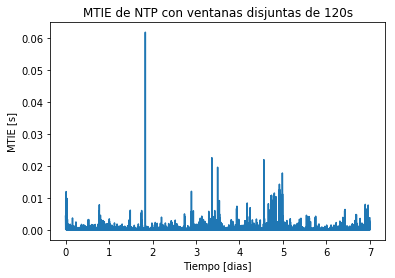

In [8]:
#Se muestra en el eje del tiempo las mediciones en dias. Para eso es necesario recalcular el indice.
indiceTiempo = np.arange(len(MTIE120))*(7/len(MTIE120))

plt.plot(indiceTiempo, MTIE120)
plt.title("MTIE de NTP con ventanas disjuntas de 120s")
plt.ylabel('MTIE [s]')
plt.xlabel('Tiempo [dias]')
plt.show()

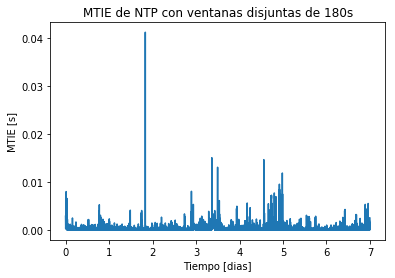

In [9]:
#Se muestra en el eje del tiempo las mediciones en dias. Para eso es necesario recalcular el indice.
indiceTiempo = np.arange(len(MTIE180))*(7/len(MTIE180)) 

plt.plot(indiceTiempo, MTIE180)
plt.title("MTIE de NTP con ventanas disjuntas de 180s")
plt.ylabel('MTIE [s]')
plt.xlabel('Tiempo [dias]')
plt.show()

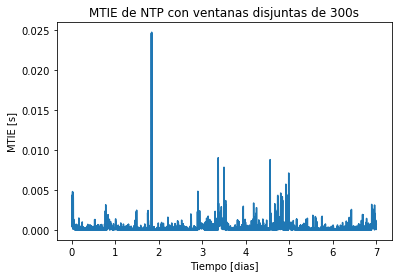

In [10]:
#Se muestra en el eje del tiempo las mediciones en dias. Para eso es necesario recalcular el indice.
indiceTiempo = np.arange(len(MTIE300))*(7/len(MTIE300)) 

plt.plot(indiceTiempo, MTIE300)
plt.title("MTIE de NTP con ventanas disjuntas de 300s")
plt.ylabel('MTIE [s]')
plt.xlabel('Tiempo [dias]')
plt.show()

Se grafica la funcion de distribucion acumulada del MTIE para NTPv4 con ventanas disjuntas y ademas se obtiene en el mismo proceso el percentil maximo de todos los tamaños de ventana lo que da una medida de que tanto offset se puede esperar en NTPv4 en el 'porcentajePercentil'% de los casos. 

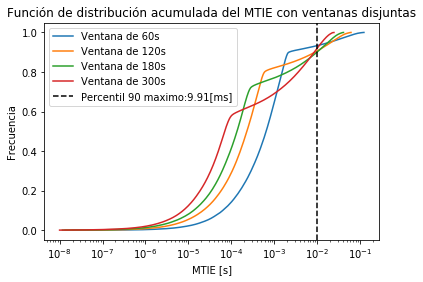

In [11]:
from nucleo import calcularFda

#Esta variable fija que percentil calcular en todos los casos hasta el final del documento
porcentajePercentil = 90

x, y = calcularFda(MTIE60)
plt.plot(x, y, label = "Ventana de 60s")
percentil = np.percentile(x, porcentajePercentil)
percentilMaximo = percentil

x, y = calcularFda(MTIE120)
plt.plot(x, y, label = "Ventana de 120s")
percentil = np.percentile(x, porcentajePercentil)
percentilMaximo = percentil if (percentilMaximo <= percentil) else percentilMaximo

x, y = calcularFda(MTIE180)
plt.plot(x, y, label = "Ventana de 180s")
percentil = np.percentile(x, porcentajePercentil)
percentilMaximo = percentil if (percentilMaximo <= percentil) else percentilMaximo

x, y = calcularFda(MTIE300)
plt.plot(x, y, label = "Ventana de 300s")
percentil = np.percentile(x, porcentajePercentil)
percentilMaximo = percentil if (percentilMaximo <= percentil) else percentilMaximo

percentilMaximoMilisegundos = percentilMaximo * 1e3

plt.legend()
plt.semilogx()

plt.ylabel('Frecuencia')
plt.xlabel('MTIE [s]')
                       
plt.axvline(x=percentilMaximo, color='k', linestyle='--', label='Percentil 90 maximo:'+('%.2f' % percentilMaximoMilisegundos)+'[ms]')
plt.legend()

plt.title("Función de distribución acumulada del MTIE con ventanas disjuntas")
plt.savefig("mtie_ntp_disj.pdf")
plt.show()



Luego se calcula y grafica el caso general del MTIE para NTPv4 con ventanas de distinto tamaño que no son disjuntas sino que se desplazan durante 
todo el intervalo de observación. Tambien se obtiene en el mismo proceso el percentil maximo de todos los tamaños de ventana lo 
que da una medida de que tanto offset se puede esperar en NTPv4 en el 'porcentajePercentil'% de los casos. 

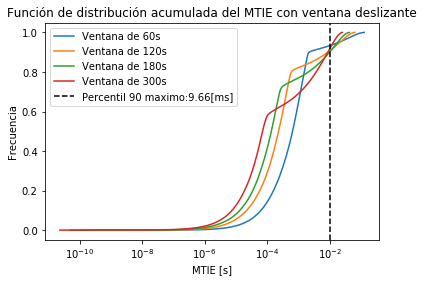

In [12]:
MTIE60 = calcularMTIE(60, phiNTPExtendido, TE, pps, 1)
MTIE120 = calcularMTIE(120, phiNTPExtendido, TE, pps, 1)
MTIE180 = calcularMTIE(180, phiNTPExtendido, TE, pps, 1)
MTIE300 = calcularMTIE(300, phiNTPExtendido, TE, pps, 1)

x, y = calcularFda(MTIE60)
plt.plot(x, y, label = "Ventana de 60s")
percentil = np.percentile(x, porcentajePercentil)

#En 'percentilMaximo' se guardara el percentil del peor caso segun sea el tamaño de la ventana.
percentilMaximo = percentil

x, y = calcularFda(MTIE120)
plt.plot(x, y, label = "Ventana de 120s")
percentil = np.percentile(x, porcentajePercentil)
percentilMaximo = percentil if (percentilMaximo <= percentil) else percentilMaximo

x, y = calcularFda(MTIE180)
plt.plot(x, y, label = "Ventana de 180s")
percentil = np.percentile(x, porcentajePercentil)
percentilMaximo = percentil if (percentilMaximo <= percentil) else percentilMaximo

x, y = calcularFda(MTIE300)
plt.plot(x, y, label = "Ventana de 300s")
percentil = np.percentile(x, porcentajePercentil)
percentilMaximo = percentil if (percentilMaximo <= percentil) else percentilMaximo

percentilMaximoMilisegundos = percentilMaximo * 1e3

plt.legend()
plt.semilogx()

plt.ylabel('Frecuencia')
plt.xlabel('MTIE [s]')
                       
plt.axvline(x=percentilMaximo, color='k', linestyle='--', label='Percentil 90 maximo:'+('%.2f' % percentilMaximoMilisegundos)+'[ms]')
plt.legend()

plt.title("Función de distribución acumulada del MTIE con ventana deslizante")
plt.savefig("mtie_ntp_desl.pdf")
plt.show()

Finalmente se calcula la varianza de Allan para NTPv4 para tener otra medida de comparacion con otros protocolos de sincronizacion de 
relojes.

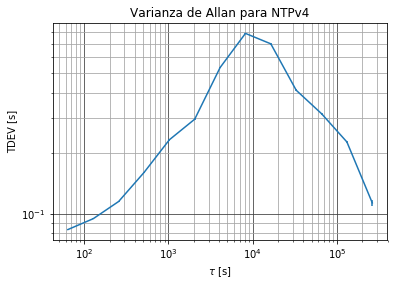

In [13]:
from allan import plotTDEV

plotTDEV(TE)